In [99]:
!pip install scikeras

In [100]:
## handling csv file and data
import numpy as np
import pandas as pd

## Plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Labelencoding function
from sklearn.preprocessing import LabelEncoder

## Scaling function
from sklearn.preprocessing import MinMaxScaler

## SMOTE function(for oversampling of minor classes)
from imblearn.over_sampling import SMOTE

## Train-test split function and hyper parameter tuning function
from sklearn.model_selection import train_test_split,GridSearchCV

## Evaluation metrics functions
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix,ConfusionMatrixDisplay

## For ignoring warnings(may not be necessary)
import warnings
warnings.filterwarnings('ignore')

In [101]:
## Required models from their respective libraries
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier

In [102]:
## importing dataset
pred_or_sev = "sev"
dataset = pd.read_csv("heart-median.csv")
dataset.shape

(623, 14)

In [103]:
if pred_or_sev == "pred":
  l=['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']
  for i in l:
    lbl=LabelEncoder()
    dataset[i] = lbl.fit_transform(dataset[i])
elif pred_or_sev == "sev":
  pass

In [104]:
predictors = dataset.drop("target",axis=1)
target = dataset["target"]
scaler = MinMaxScaler()
predictors = scaler.fit_transform(predictors)

In [105]:
X_train, X_test, Y_train, Y_test = train_test_split(predictors,target,test_size=0.20,random_state=0)

oversample = SMOTE()
predictors_SMOTE,target_SMOTE = oversample.fit_resample(predictors, target)
X_train_SMOTE, X_test_SMOTE, Y_train_SMOTE, Y_test_SMOTE = train_test_split(predictors_SMOTE,target_SMOTE,test_size=0.20,random_state=0)


In [106]:
def create_model(optimizer='adam', activation='relu', neurons=64):
    model = Sequential()
    input_dim = 13
    if pred_or_sev == "pred":
      input_dim = 11
    model.add(Dense(neurons, input_dim=input_dim, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Define the hyperparameters grid
parameters = {
    'batch_size': [16, 32, 64],
    'epochs': [10, 20, 30],
    'neurons': [32, 64, 128],
    'optimizer': ['adam', 'rmsprop'],
    'activation': ['relu', 'tanh']
}

# Create a KerasClassifier based on the model
model = KerasClassifier(build_fn=create_model, verbose=0)

In [107]:
print(model)

KerasClassifier(
	model=None
	build_fn=<function create_model at 0x794d380bdf30>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	class_weight=None
)


In [108]:
def ac(Y_test, Y_pred):
  return round(accuracy_score(Y_test,Y_pred)*100,2)

def ps(Y_test, Y_pred):
  if pred_or_sev == "pred":
    return round(precision_score(Y_test,Y_pred)*100,2)
  else:
    return round(precision_score(Y_test,Y_pred, average='micro')*100,2)

def rs(Y_test, Y_pred):
  if pred_or_sev == "pred":
    return round(recall_score(Y_test,Y_pred)*100,2)
  else:
    return round(recall_score(Y_test,Y_pred, average='micro')*100,2)

def f1(Y_test, Y_pred):
  if pred_or_sev == "pred":
    return round(f1_score(Y_test,Y_pred)*100,2)
  else:
    return round(f1_score(Y_test,Y_pred, average='micro')*100,2)

In [109]:
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)

acc3 = ac(Y_test, Y_pred)

prec3 = ps(Y_test, Y_pred)

rec3 = rs(Y_test, Y_pred)

f1_3 = f1(Y_test, Y_pred)

In [110]:
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test_SMOTE)

acc4 = ac(Y_test_SMOTE, Y_pred)

prec4 = ps(Y_test_SMOTE, Y_pred)

rec4 = rs(Y_test_SMOTE, Y_pred)

f1_4 = f1(Y_test_SMOTE, Y_pred)

In [111]:
import pandas as pd
from pandas.io.formats.style import Styler

column_names = pd.DataFrame([["With gridsearch", "Without SMOTE"],
                             ["With gridsearch", "With SMOTE"]],
                             columns=["Metric", ""])

rows = [[acc3,acc4],
        [prec3,prec4],
        [rec3,rec4],
        [f1_3,f1_4]]

columns = pd.MultiIndex.from_frame(column_names)
index = ["accuracy", "precision", "recall", "f1"]

df = pd.DataFrame(rows, columns=columns, index=index)

styler = Styler(df,precision = 2)
styler.set_properties(**{'text-align': 'center'})

display(styler)

In [112]:
labels = [0,1]
if pred_or_sev == "sev":
    labels = [0,1,2,3,4]

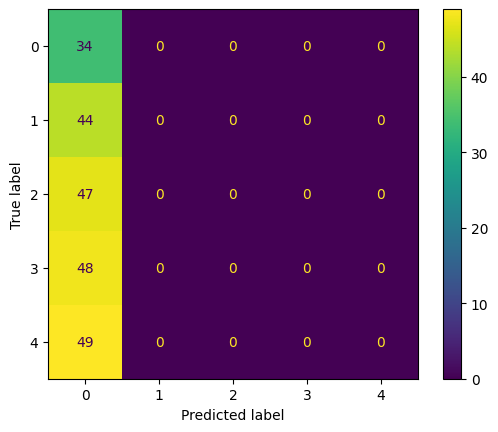

In [113]:
c = confusion_matrix(Y_test_SMOTE, Y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = c, display_labels = labels)

cm_display.plot()

plt.savefig("Confusion_matrix_NN.jpeg")
plt.show()